<a href="https://colab.research.google.com/github/varinen/handson-unsupervised-learning/blob/master/Chap08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-On Autoencoder

In the previous chapters, we have been working with a dataset of credit card transactions. There are 284807 transactions out of which 492 are fraudulent. Using a supervised model we were able to reach 0.82 precision. We could find 80% fraud with 80% accuracy. Then, we tried several unsupervised algorithms and achieved a 0.69 precision, which is quite impressive, given we used no labels. We were able to detect over 75% fraud with 75% accuracy.

Now, we will try to solve the fraud detection problem using an autoencoder.

In [0]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [0]:
# Load the data
# In collab - use the code below
current_path = os.getcwd()
#file = '\\datasets\\credit_card_data\\credit_card.csv'
#data = pd.read_csv(file)

In [9]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()


     |████████████████████████████████| 993kB 2.9MB/s 


In [0]:

drive = GoogleDrive(gauth)

In [11]:
link = 'https://drive.google.com/open?id=1kEH7mXyYvtduSntlTS-40XAcpSMBoFyf'
fluff, id = link.split('=')
print(id)

1kEH7mXyYvtduSntlTS-40XAcpSMBoFyf


In [12]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
data = pd.read_csv('Filename.csv')

W0614 15:27:00.845352 139851435644800 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNo

In [13]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We are going to create a feature matrix that contains all the PCA components (V columns) and the `Amount` column. We are going to drop `Time` and `Class`. The latter will be stored in a separate matrix for labels.

In [0]:
dataX = data.copy().drop(['Class', 'Time'], axis=1)
dataY = data['Class'].copy()


The next step is to scale the data:

In [0]:
featuresToScale = dataX.columns

sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)

dataX.loc[:, featuresToScale] = sX.fit_transform(dataX[featuresToScale])

We will create a training set with two-thirds of the dataset and a test set with one-third of the data.

In [0]:
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY)
X_train_AE = X_train.copy()
X_test_AE = X_test.copy()

To measure the anomaly scores we will need a function that evaluates the reconstruction error as the sum of squared differences and normalizes them to a range between 0 and 1.

The transactions with the highest reconstruction error can be judged as anomalous because their patterns are not well reflected in the PCA.

In [0]:
def anomalyScores(originalDF, reducedDF):
  loss = np.sum((np.array(originalDF) - np.array(reducedDF)) ** 2,
                axis=1)
  
  loss =pd.Series(data=loss, index=originalDF.index)
  
  # subtract the minimum and divide by the range
  loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss))
  return loss

We also will need a function to plot the results as a precision-recall curve, average precision, and a ROC curve.

In [0]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

## The Components of an Autoencoder

We will build a simple autoencoder consisting of an input layer, one hidden layer, and an output layer. 

The data matrix $x$ will be fed into the autoencoder and an activation function will be applied to these data generating the hidden layer. This activation function is the *encoder* part of the function and can be represented as $h= f(x)$. Now, $h$ is the *learned representation* which is passed to the hidden layer where a reconstruction function is applied to it. This generates the reconstructed representation $r = g(h)$. The function $g$ is the *decoder* part of the autoencoder and $r$ is the output layer.

The activation function takes an input $Y$ and either activates (when $Y$ is above a threshold) or not. We do not need simple binary activations. Instead, we want to activate for a range of values. We can choose a linear function or a non-linear activation function. The linear function is unbounded and can generate values between the positive and the negative infinity. Common nonlinear functions include *sigmoid*, *hyperbolic tangent*,  *rectified linear unit (ReLU)*, and *softwax*.

#### Sigmoid function

The sigmoid function is bounded and can generate values between 0 and 1.

#### Tahn function

The tahn (hyperbolic tangent) function is also bounded and can generate values between negative one and positive one. Its gradient is steeper than that of the sigmoid function.

#### ReLU
 
 The ReLU function has an interesting property. If $Y$ is positive, ReLU will return $Y$, otherwise, it will return zero. That means ReLU is unbounded for positive values of $Y$.
 
 #### Softmax function
 
 The softmax function is used as the final activation function in a neural network. It normalizes the class probabilities and adds up to 1.
 
 Of these functions, the linear function is the simplest and least computationally expensive. ReLU is the next least computationally expensive, followed by others.
 
 
 
 ## Out First Autoencoder
 
 So, out first autoencoder will contain two layers (counting only the hidden and the output layers) with a linear activation function for both the encoder and decoder.
 
 The *Sequential model API* by Keras represent a model as a linear stack of layers

In [17]:
# Call neural network API
model = Sequential()

# Apply linear activation function to the input layer
# Generate the hidden layer with 29 nodes, the same as the input layer
model.add(Dense(units=29, activation='linear', input_dim=29))

# Apply linear activation function to the hidden layer
model.add(Dense(units=29, activation='linear'))

Instructions for updating:
Colocations handled automatically by placer.


### Loss Function

We are going to evaluate the model based on the reconstruction error. Thus. our loss function is `mean_squared_error`.

### Optimizer

Neural networks are trained in rounds (epochs). After each epoch, the network readjusts the node weights to reduce loss from the previous epoch. This process of learning is defined by the optimizer.

To learn the optimal weights, the system has to intelligently guess them. One way is to iteratively change the ways in the direction that reduces the loss. An even better way is to change the weights with a degree of randomness (stochasticity).

One such algorithm is known as *Stochastic Gradient Descent* (SDG). SDG uses the same pre-set learning rates in all epochs. However, it may be better to be able to adjust the learning rate during the training. In earlier epochs, the learning rate can be larger to save time on training. In later epochs it is better to make smaller steps so that not to overshoot over the optimum. For this approach, we have an even better optimizer: *Adam optimization algorithm* (derived from adaptive moment estimation). Adam optimizer automatically adjusts the learning rate as the training goes.

### Hyperparameters

We need to select the number of training iterations (epochs) and the batch size. The former we set to 10. The batch size defines the number of samples that the network trains on before making the next gradient update. If the batch size is equal to the number of observations, the network will make only one gradient update per epoch. Otherwise, it will perform several gradient updates. We try the batch size 32 to start.

In [0]:
# Compile the model:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [22]:
# Train the model
num_epochs = 10
batch_size = 32


history = model.fit(x=X_train_AE, y=X_train_AE,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_train_AE, X_train_AE),
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 9s 46us/step - loss: 0.0714 - acc: 0.9028 - val_loss: 0.0066 - val_acc: 0.9793
Epoch 2/10
190820/190820 [==============================] - 8s 43us/step - loss: 9.2206e-04 - acc: 0.9906 - val_loss: 0.0020 - val_acc: 0.9852
Epoch 3/10
190820/190820 [==============================] - 8s 43us/step - loss: 7.1249e-04 - acc: 0.9935 - val_loss: 3.8908e-04 - val_acc: 0.9911
Epoch 4/10
190820/190820 [==============================] - 8s 42us/step - loss: 4.4934e-04 - acc: 0.9951 - val_loss: 4.3599e-05 - val_acc: 0.9960
Epoch 5/10
190820/190820 [==============================] - 8s 43us/step - loss: 0.0010 - acc: 0.9932 - val_loss: 8.7012e-06 - val_acc: 0.9988
Epoch 6/10
190820/190820 [==============================] - 8s 43us/step - loss: 5.1553e-04 - acc: 0.9954 - val_loss: 4.8276e-06 - val_acc: 0.9987
Epoch 7/10
190820/190820 [========

It must be no surprise that the accuracy is so high and the loss is so low: the hidden layer has the same number of dimensions as the input. This makes our autoencoder __complete__.

### Evaluating the Test Set

Let's now use our test set to see how the trained model will perform:



93987/93987 [==============================] - 1s 10us/step


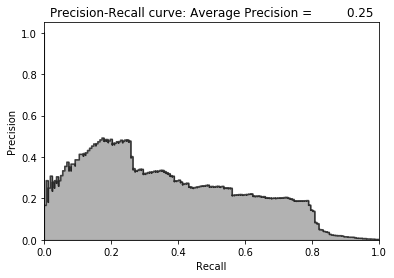

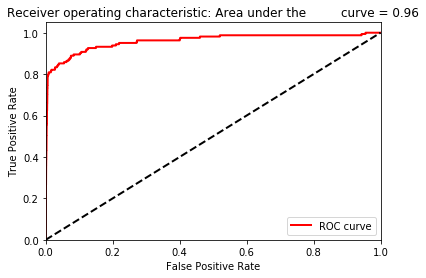

In [25]:
# Evaluate on test set
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)
model.reset_states()

Now, we will simulate the run ten times to get the average evaluation metrics. The batches will be shuffled:

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 9s 45us/step - loss: 0.0813 - acc: 0.8920 - val_loss: 5.7520e-04 - val_acc: 0.9923
Epoch 2/10
190820/190820 [==============================] - 8s 44us/step - loss: 6.3532e-04 - acc: 0.9935 - val_loss: 0.0010 - val_acc: 0.9887
Epoch 3/10
190820/190820 [==============================] - 8s 43us/step - loss: 5.7760e-04 - acc: 0.9941 - val_loss: 0.0012 - val_acc: 0.9854
Epoch 4/10
190820/190820 [==============================] - 8s 44us/step - loss: 7.2911e-04 - acc: 0.9937 - val_loss: 5.3366e-05 - val_acc: 0.9964
Epoch 5/10
190820/190820 [==============================] - 8s 43us/step - loss: 4.9556e-04 - acc: 0.9940 - val_loss: 0.0011 - val_acc: 0.9981
Epoch 6/10
190820/190820 [==============================] - 8s 44us/step - loss: 4.9674e-04 - acc: 0.9951 - val_loss: 1.5246e-06 - val_acc: 0.9996
Epoch 7/10
190820/190820 [==============================] - 8s 43us/step - loss: 5

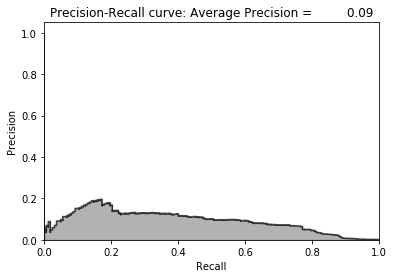

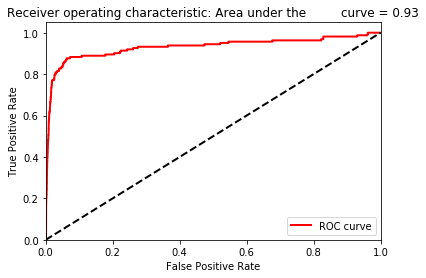

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 9s 46us/step - loss: 0.0738 - acc: 0.9029 - val_loss: 0.0023 - val_acc: 0.9786
Epoch 2/10
190820/190820 [==============================] - 8s 44us/step - loss: 0.0010 - acc: 0.9898 - val_loss: 7.1917e-06 - val_acc: 0.9992
Epoch 3/10
190820/190820 [==============================] - 8s 44us/step - loss: 6.5117e-04 - acc: 0.9941 - val_loss: 0.0065 - val_acc: 0.9691
Epoch 4/10
190820/190820 [==============================] - 9s 45us/step - loss: 6.0160e-04 - acc: 0.9939 - val_loss: 2.2268e-07 - val_acc: 0.9998
Epoch 5/10
190820/190820 [==============================] - 9s 45us/step - loss: 5.0127e-04 - acc: 0.9954 - val_loss: 0.0035 - val_acc: 0.9738
Epoch 6/10
190820/190820 [==============================] - 9s 45us/step - loss: 6.9992e-04 - acc: 0.9937 - val_loss: 4.7784e-04 - val_acc: 0.9887
Epoch 7/10
190820/190820 [==============================] - 8s 44us/step - loss: 3.993

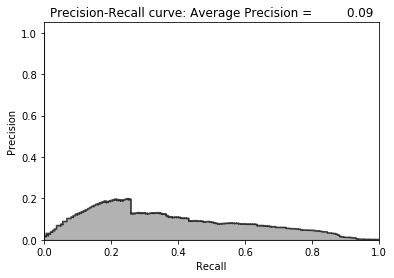

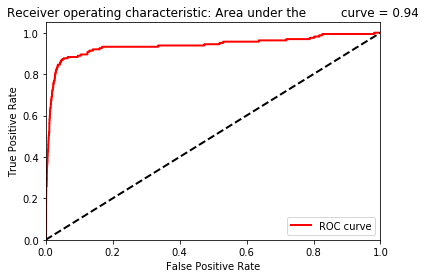

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 9s 46us/step - loss: 0.1127 - acc: 0.8687 - val_loss: 0.0013 - val_acc: 0.9910
Epoch 2/10
190820/190820 [==============================] - 9s 46us/step - loss: 0.0014 - acc: 0.9892 - val_loss: 4.5996e-05 - val_acc: 0.9955
Epoch 3/10
190820/190820 [==============================] - 9s 45us/step - loss: 5.7658e-04 - acc: 0.9952 - val_loss: 0.0014 - val_acc: 0.9939
Epoch 4/10
190820/190820 [==============================] - 9s 46us/step - loss: 7.2815e-04 - acc: 0.9936 - val_loss: 2.0118e-05 - val_acc: 0.9986
Epoch 5/10
190820/190820 [==============================] - 9s 45us/step - loss: 8.8365e-04 - acc: 0.9946 - val_loss: 8.6102e-06 - val_acc: 0.9977
Epoch 6/10
190820/190820 [==============================] - 9s 46us/step - loss: 4.8916e-04 - acc: 0.9946 - val_loss: 0.0014 - val_acc: 0.9826
Epoch 7/10
190820/190820 [==============================] - 9s 46us/step - loss: 5.377

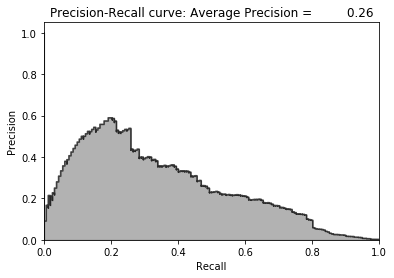

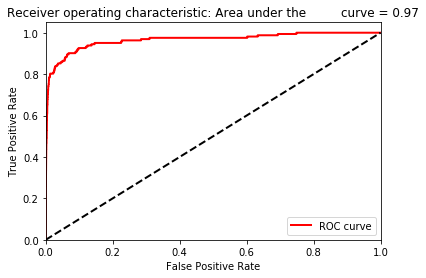

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 9s 47us/step - loss: 0.0847 - acc: 0.8880 - val_loss: 0.0026 - val_acc: 0.9779
Epoch 2/10
190820/190820 [==============================] - 9s 46us/step - loss: 7.9085e-04 - acc: 0.9916 - val_loss: 3.9770e-06 - val_acc: 0.9986
Epoch 3/10
190820/190820 [==============================] - 9s 46us/step - loss: 8.7005e-04 - acc: 0.9931 - val_loss: 2.3805e-06 - val_acc: 0.9993
Epoch 4/10
190820/190820 [==============================] - 9s 46us/step - loss: 6.3023e-04 - acc: 0.9944 - val_loss: 2.9424e-04 - val_acc: 0.9937
Epoch 5/10
190820/190820 [==============================] - 9s 46us/step - loss: 4.7978e-04 - acc: 0.9957 - val_loss: 1.1632e-05 - val_acc: 0.9987
Epoch 6/10
190820/190820 [==============================] - 9s 45us/step - loss: 5.6517e-04 - acc: 0.9949 - val_loss: 3.5069e-04 - val_acc: 0.9934
Epoch 7/10
190820/190820 [==============================] - 9s 46us/step -

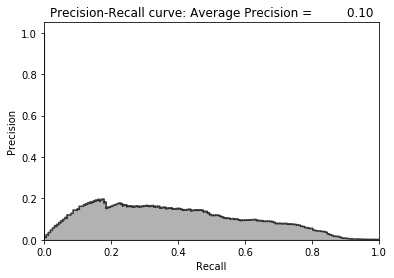

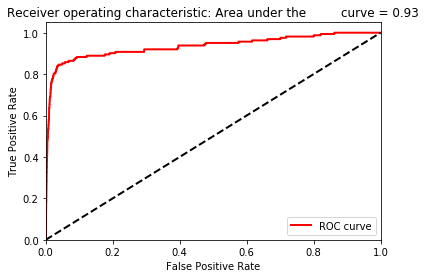

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.0723 - acc: 0.9086 - val_loss: 0.0025 - val_acc: 0.9792
Epoch 2/10
190820/190820 [==============================] - 9s 47us/step - loss: 0.0011 - acc: 0.9924 - val_loss: 1.9313e-06 - val_acc: 0.9993
Epoch 3/10
190820/190820 [==============================] - 9s 47us/step - loss: 4.4921e-04 - acc: 0.9959 - val_loss: 1.5008e-05 - val_acc: 0.9992
Epoch 4/10
190820/190820 [==============================] - 9s 48us/step - loss: 6.8382e-04 - acc: 0.9931 - val_loss: 3.0000e-05 - val_acc: 0.9988
Epoch 5/10
190820/190820 [==============================] - 9s 47us/step - loss: 4.6613e-04 - acc: 0.9938 - val_loss: 3.5038e-04 - val_acc: 0.9907
Epoch 6/10
190820/190820 [==============================] - 9s 47us/step - loss: 5.4304e-04 - acc: 0.9941 - val_loss: 5.4105e-07 - val_acc: 0.9997
Epoch 7/10
190820/190820 [==============================] - 9s 47us/step - los

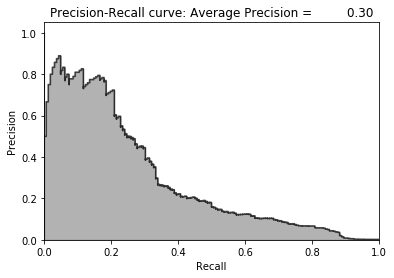

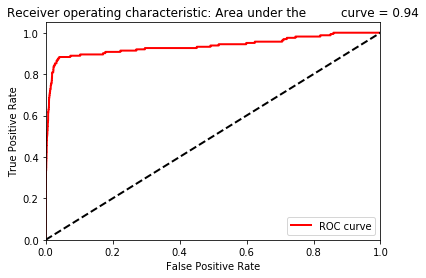

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 9s 49us/step - loss: 0.0712 - acc: 0.9074 - val_loss: 0.0027 - val_acc: 0.9837
Epoch 2/10
190820/190820 [==============================] - 9s 48us/step - loss: 9.0142e-04 - acc: 0.9923 - val_loss: 0.0015 - val_acc: 0.9952
Epoch 3/10
190820/190820 [==============================] - 9s 48us/step - loss: 8.5388e-04 - acc: 0.9927 - val_loss: 2.9750e-06 - val_acc: 0.9994
Epoch 4/10
190820/190820 [==============================] - 9s 48us/step - loss: 5.5554e-04 - acc: 0.9948 - val_loss: 0.0012 - val_acc: 0.9825
Epoch 5/10
190820/190820 [==============================] - 9s 48us/step - loss: 7.1763e-04 - acc: 0.9945 - val_loss: 7.6417e-04 - val_acc: 0.9909
Epoch 6/10
190820/190820 [==============================] - 9s 48us/step - loss: 5.4989e-04 - acc: 0.9947 - val_loss: 8.6622e-07 - val_acc: 0.9995
Epoch 7/10
190820/190820 [==============================] - 9s 48us/step - loss: 5

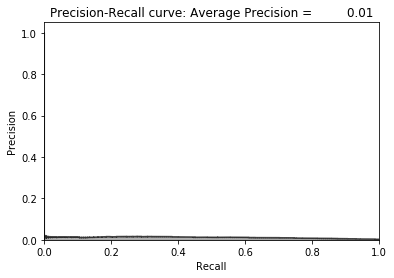

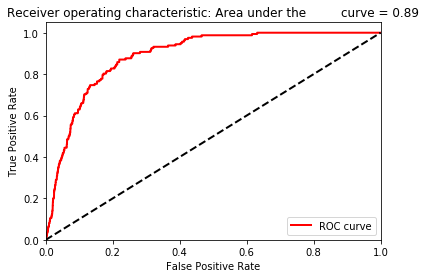

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 50us/step - loss: 0.0698 - acc: 0.9066 - val_loss: 0.0015 - val_acc: 0.9874
Epoch 2/10
190820/190820 [==============================] - 9s 48us/step - loss: 0.0014 - acc: 0.9899 - val_loss: 6.9608e-07 - val_acc: 0.9998
Epoch 3/10
190820/190820 [==============================] - 10s 52us/step - loss: 6.0529e-04 - acc: 0.9951 - val_loss: 9.2671e-08 - val_acc: 0.9998
Epoch 4/10
190820/190820 [==============================] - 9s 48us/step - loss: 8.2637e-04 - acc: 0.9950 - val_loss: 2.8767e-08 - val_acc: 0.9999
Epoch 5/10
190820/190820 [==============================] - 9s 48us/step - loss: 4.9888e-04 - acc: 0.9942 - val_loss: 3.7731e-04 - val_acc: 0.9909
Epoch 6/10
190820/190820 [==============================] - 9s 48us/step - loss: 6.2201e-04 - acc: 0.9943 - val_loss: 0.0039 - val_acc: 0.9767
Epoch 7/10
190820/190820 [==============================] - 9s 48us/step - loss:

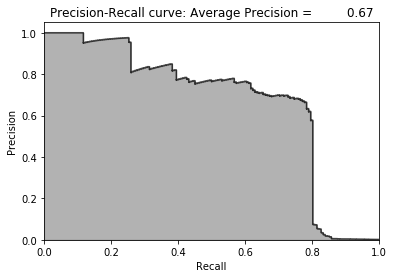

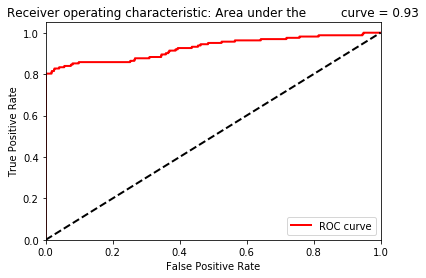

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 50us/step - loss: 0.0725 - acc: 0.9018 - val_loss: 0.0017 - val_acc: 0.9901
Epoch 2/10
190820/190820 [==============================] - 9s 49us/step - loss: 0.0024 - acc: 0.9854 - val_loss: 9.0159e-04 - val_acc: 0.9922
Epoch 3/10
190820/190820 [==============================] - 9s 49us/step - loss: 6.5574e-04 - acc: 0.9934 - val_loss: 1.4696e-05 - val_acc: 0.9977
Epoch 4/10
190820/190820 [==============================] - 9s 49us/step - loss: 6.4900e-04 - acc: 0.9936 - val_loss: 2.3857e-05 - val_acc: 0.9992
Epoch 5/10
190820/190820 [==============================] - 9s 48us/step - loss: 4.8895e-04 - acc: 0.9938 - val_loss: 5.0224e-04 - val_acc: 0.9908
Epoch 6/10
190820/190820 [==============================] - 9s 49us/step - loss: 4.7549e-04 - acc: 0.9946 - val_loss: 9.7376e-06 - val_acc: 0.9982
Epoch 7/10
190820/190820 [==============================] - 10s 50us/step - l

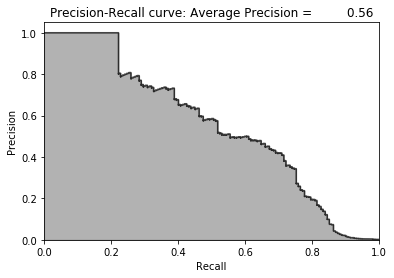

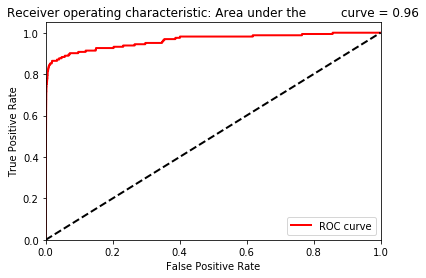

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 52us/step - loss: 0.0773 - acc: 0.8930 - val_loss: 4.1569e-04 - val_acc: 0.9945
Epoch 2/10
190820/190820 [==============================] - 9s 49us/step - loss: 7.4794e-04 - acc: 0.9937 - val_loss: 2.6456e-07 - val_acc: 0.9998
Epoch 3/10
190820/190820 [==============================] - 9s 49us/step - loss: 5.6375e-04 - acc: 0.9943 - val_loss: 0.0010 - val_acc: 0.9873
Epoch 4/10
190820/190820 [==============================] - 9s 49us/step - loss: 0.0010 - acc: 0.9942 - val_loss: 2.1742e-08 - val_acc: 0.9999
Epoch 5/10
190820/190820 [==============================] - 9s 49us/step - loss: 0.0013 - acc: 0.9927 - val_loss: 5.1278e-06 - val_acc: 0.9992
Epoch 6/10
190820/190820 [==============================] - 9s 49us/step - loss: 6.0208e-04 - acc: 0.9942 - val_loss: 0.0021 - val_acc: 0.9877
Epoch 7/10
190820/190820 [==============================] - 9s 49us/step - loss: 4.55

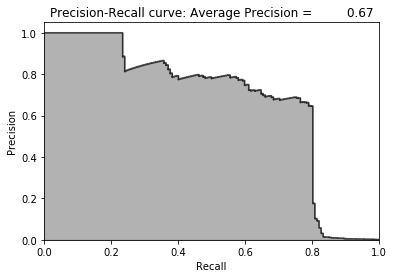

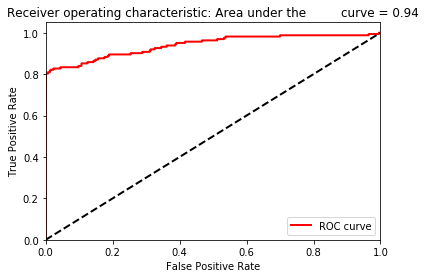

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 10s 52us/step - loss: 0.0729 - acc: 0.9048 - val_loss: 7.5210e-04 - val_acc: 0.9933
Epoch 2/10
190820/190820 [==============================] - 10s 51us/step - loss: 8.6842e-04 - acc: 0.9915 - val_loss: 2.4816e-05 - val_acc: 0.9980
Epoch 3/10
190820/190820 [==============================] - 10s 50us/step - loss: 5.8579e-04 - acc: 0.9948 - val_loss: 1.2214e-05 - val_acc: 0.9980
Epoch 4/10
190820/190820 [==============================] - 10s 51us/step - loss: 5.5140e-04 - acc: 0.9947 - val_loss: 2.1408e-04 - val_acc: 0.9935
Epoch 5/10
190820/190820 [==============================] - 10s 54us/step - loss: 7.8752e-04 - acc: 0.9937 - val_loss: 9.2329e-04 - val_acc: 0.9930
Epoch 6/10
190820/190820 [==============================] - 10s 52us/step - loss: 4.2947e-04 - acc: 0.9955 - val_loss: 0.0080 - val_acc: 0.9666
Epoch 7/10
190820/190820 [==============================] - 10s 50us

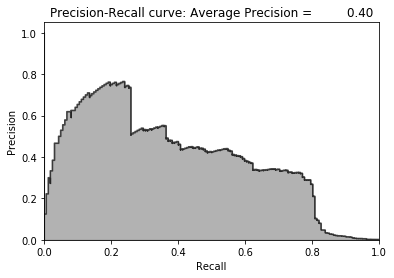

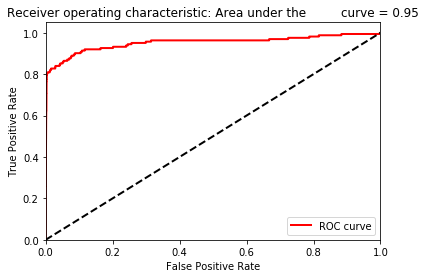

Mean average precision over 10 runs:  0.3144429073715232


[0.09154571756401024,
 0.08618271754065798,
 0.25945972982838533,
 0.10310513812072603,
 0.2953628683115887,
 0.011528041467960264,
 0.6682378299903233,
 0.5581517191393688,
 0.6743991157552537,
 0.3964561959969578]

In [26]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 29 nodes, the same as the input layer
    model.add(Dense(units=29, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [27]:
# Results
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.3144429073715232
Coefficient of variation over 10 runs:  0.7542260973826989


[0.09154571756401024,
 0.08618271754065798,
 0.25945972982838533,
 0.10310513812072603,
 0.2953628683115887,
 0.011528041467960264,
 0.6682378299903233,
 0.5581517191393688,
 0.6743991157552537,
 0.3964561959969578]

The average accuracy  over ten runs is 0.31, but it varies much from one run to another, from as low as 0.01 to the highest of 0.67. The standard deviation of these 10 scores is high: .88

Letäs try to improve the autoencoder by building its variations.

## Two-Layer Undercomplete Autoencoder with a Linear activation function

First, we try an undercomplete autoencoder rather than a complete one. We will constrain the number of nodes in the hidden layer to 20. This will force the autoencoder to capture more salient information from the input.

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 55us/step - loss: 0.3493 - acc: 0.5127 - val_loss: 0.2785 - val_acc: 0.5414
Epoch 2/10
190820/190820 [==============================] - 10s 52us/step - loss: 0.2816 - acc: 0.5463 - val_loss: 0.2776 - val_acc: 0.5504
Epoch 3/10
190820/190820 [==============================] - 10s 52us/step - loss: 0.2804 - acc: 0.5608 - val_loss: 0.2754 - val_acc: 0.5641
Epoch 4/10
190820/190820 [==============================] - 10s 51us/step - loss: 0.2788 - acc: 0.5627 - val_loss: 0.2757 - val_acc: 0.5705
Epoch 5/10
190820/190820 [==============================] - 10s 52us/step - loss: 0.2783 - acc: 0.5709 - val_loss: 0.2744 - val_acc: 0.5755
Epoch 6/10
190820/190820 [==============================] - 10s 52us/step - loss: 0.2775 - acc: 0.5762 - val_loss: 0.2745 - val_acc: 0.5762
Epoch 7/10
190820/190820 [==============================] - 10s 52us/step - loss: 0.2774 - acc: 0.5819 - val

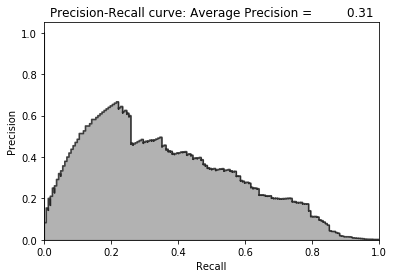

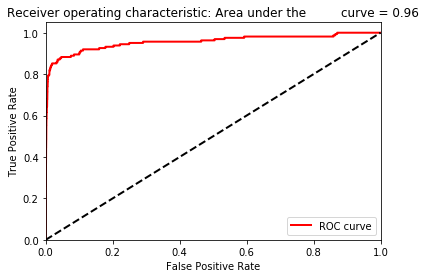

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.3516 - acc: 0.5569 - val_loss: 0.2779 - val_acc: 0.5987
Epoch 2/10
190820/190820 [==============================] - 10s 52us/step - loss: 0.2821 - acc: 0.5961 - val_loss: 0.2765 - val_acc: 0.5956
Epoch 3/10
190820/190820 [==============================] - 10s 53us/step - loss: 0.2797 - acc: 0.5961 - val_loss: 0.2753 - val_acc: 0.6031
Epoch 4/10
190820/190820 [==============================] - 10s 52us/step - loss: 0.2777 - acc: 0.6053 - val_loss: 0.2751 - val_acc: 0.5961
Epoch 5/10
190820/190820 [==============================] - 10s 52us/step - loss: 0.2784 - acc: 0.5986 - val_loss: 0.2753 - val_acc: 0.5992
Epoch 6/10
190820/190820 [==============================] - 10s 53us/step - loss: 0.2782 - acc: 0.5973 - val_loss: 0.2794 - val_acc: 0.5992
Epoch 7/10
190820/190820 [==============================] - 10s 53us/step - loss: 0.2773 - acc: 0.6000 - val

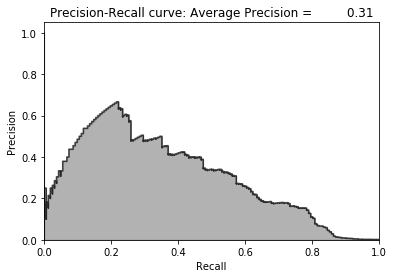

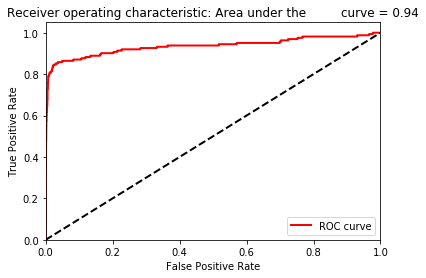

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.3384 - acc: 0.5482 - val_loss: 0.2778 - val_acc: 0.5644
Epoch 2/10
190820/190820 [==============================] - 10s 54us/step - loss: 0.2810 - acc: 0.5645 - val_loss: 0.2767 - val_acc: 0.5600
Epoch 3/10
190820/190820 [==============================] - 10s 53us/step - loss: 0.2814 - acc: 0.5778 - val_loss: 0.2754 - val_acc: 0.5825
Epoch 4/10
190820/190820 [==============================] - 10s 53us/step - loss: 0.2782 - acc: 0.5908 - val_loss: 0.2752 - val_acc: 0.5958
Epoch 5/10
190820/190820 [==============================] - 10s 53us/step - loss: 0.2778 - acc: 0.6029 - val_loss: 0.2753 - val_acc: 0.6022
Epoch 6/10
190820/190820 [==============================] - 10s 53us/step - loss: 0.2783 - acc: 0.5936 - val_loss: 0.2746 - val_acc: 0.6077
Epoch 7/10
190820/190820 [==============================] - 10s 54us/step - loss: 0.2777 - acc: 0.6157 - val

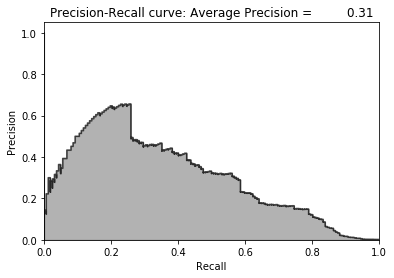

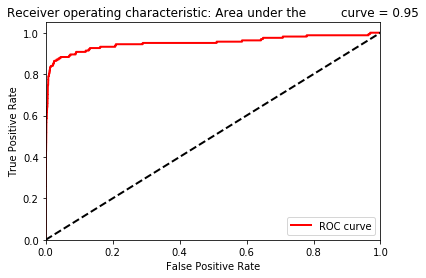

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.3448 - acc: 0.5451 - val_loss: 0.2778 - val_acc: 0.5745
Epoch 2/10
190820/190820 [==============================] - 10s 54us/step - loss: 0.2810 - acc: 0.5874 - val_loss: 0.2763 - val_acc: 0.5787
Epoch 3/10
190820/190820 [==============================] - 10s 53us/step - loss: 0.2801 - acc: 0.5907 - val_loss: 0.2750 - val_acc: 0.5828
Epoch 4/10
190820/190820 [==============================] - 10s 54us/step - loss: 0.2794 - acc: 0.5806 - val_loss: 0.2749 - val_acc: 0.5783
Epoch 5/10
190820/190820 [==============================] - 10s 54us/step - loss: 0.2784 - acc: 0.5776 - val_loss: 0.2746 - val_acc: 0.5751
Epoch 6/10
190820/190820 [==============================] - 10s 54us/step - loss: 0.2787 - acc: 0.5810 - val_loss: 0.2745 - val_acc: 0.5799
Epoch 7/10
190820/190820 [==============================] - 10s 54us/step - loss: 0.2775 - acc: 0.5845 - val

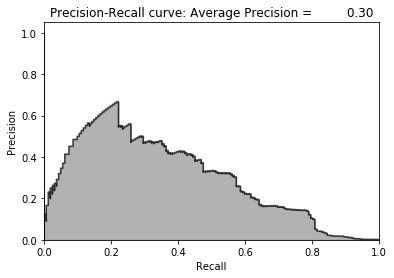

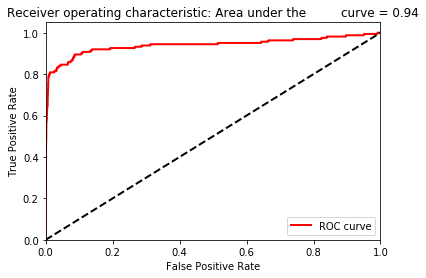

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.3399 - acc: 0.5058 - val_loss: 0.2779 - val_acc: 0.5324
Epoch 2/10
190820/190820 [==============================] - 10s 55us/step - loss: 0.2817 - acc: 0.5461 - val_loss: 0.2759 - val_acc: 0.5326
Epoch 3/10
190820/190820 [==============================] - 10s 54us/step - loss: 0.2789 - acc: 0.5379 - val_loss: 0.2766 - val_acc: 0.5325
Epoch 4/10
190820/190820 [==============================] - 11s 55us/step - loss: 0.2785 - acc: 0.5346 - val_loss: 0.2778 - val_acc: 0.5458
Epoch 5/10
190820/190820 [==============================] - 10s 55us/step - loss: 0.2780 - acc: 0.5513 - val_loss: 0.2758 - val_acc: 0.5434
Epoch 6/10
190820/190820 [==============================] - 10s 55us/step - loss: 0.2783 - acc: 0.5429 - val_loss: 0.2753 - val_acc: 0.5435
Epoch 7/10
190820/190820 [==============================] - 10s 55us/step - loss: 0.2781 - acc: 0.5395 - val

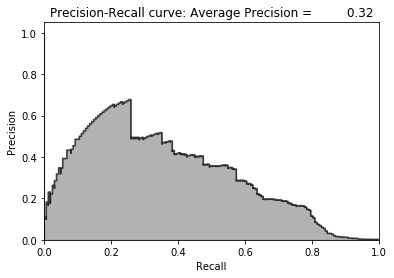

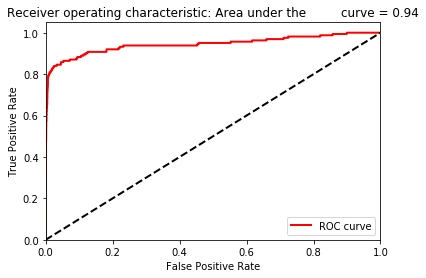

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.3391 - acc: 0.5559 - val_loss: 0.2783 - val_acc: 0.5800
Epoch 2/10
190820/190820 [==============================] - 10s 55us/step - loss: 0.2827 - acc: 0.5979 - val_loss: 0.2766 - val_acc: 0.5765
Epoch 3/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.2803 - acc: 0.5614 - val_loss: 0.2758 - val_acc: 0.5758
Epoch 4/10
190820/190820 [==============================] - 11s 55us/step - loss: 0.2793 - acc: 0.6155 - val_loss: 0.2758 - val_acc: 0.6137
Epoch 5/10
190820/190820 [==============================] - 10s 55us/step - loss: 0.2793 - acc: 0.6082 - val_loss: 0.2753 - val_acc: 0.6170
Epoch 6/10
190820/190820 [==============================] - 11s 55us/step - loss: 0.2786 - acc: 0.6133 - val_loss: 0.2751 - val_acc: 0.6070
Epoch 7/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.2777 - acc: 0.6046 - val

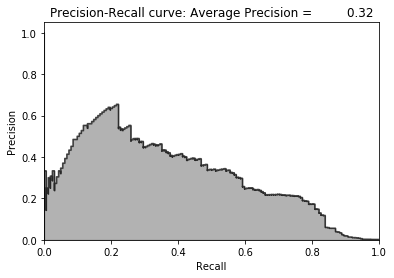

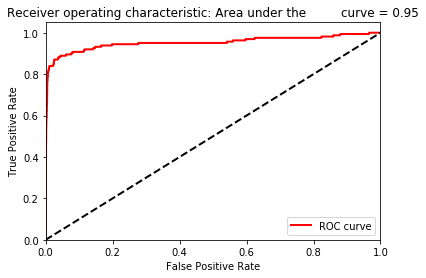

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.3481 - acc: 0.5566 - val_loss: 0.2781 - val_acc: 0.5927
Epoch 2/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.2820 - acc: 0.5876 - val_loss: 0.2765 - val_acc: 0.5650
Epoch 3/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.2796 - acc: 0.5601 - val_loss: 0.2767 - val_acc: 0.5765
Epoch 4/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.2795 - acc: 0.5695 - val_loss: 0.2756 - val_acc: 0.5770
Epoch 5/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.2791 - acc: 0.5716 - val_loss: 0.2756 - val_acc: 0.5741
Epoch 6/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.2778 - acc: 0.5820 - val_loss: 0.2747 - val_acc: 0.5774
Epoch 7/10
190820/190820 [==============================] - 11s 55us/step - loss: 0.2779 - acc: 0.5787 - val

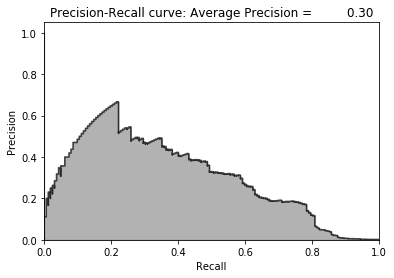

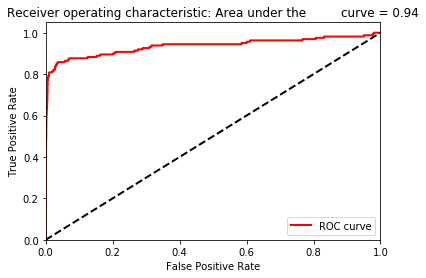

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 61us/step - loss: 0.3445 - acc: 0.4995 - val_loss: 0.2786 - val_acc: 0.5514
Epoch 2/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.2813 - acc: 0.5640 - val_loss: 0.2792 - val_acc: 0.5617
Epoch 3/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.2803 - acc: 0.5565 - val_loss: 0.2761 - val_acc: 0.5736
Epoch 4/10
190820/190820 [==============================] - 11s 56us/step - loss: 0.2790 - acc: 0.5708 - val_loss: 0.2748 - val_acc: 0.5844
Epoch 5/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.2782 - acc: 0.5876 - val_loss: 0.2753 - val_acc: 0.5904
Epoch 6/10
190820/190820 [==============================] - 11s 60us/step - loss: 0.2787 - acc: 0.5942 - val_loss: 0.2750 - val_acc: 0.5947
Epoch 7/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.2779 - acc: 0.5936 - val

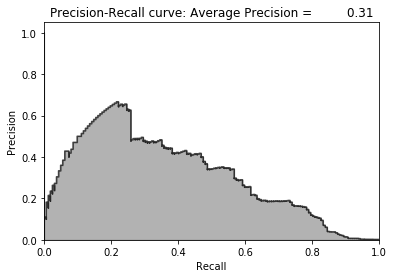

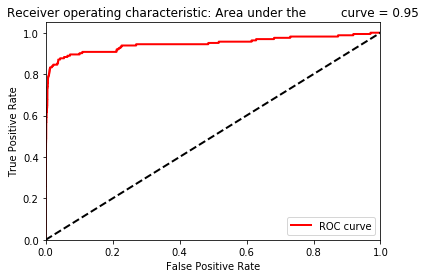

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.3369 - acc: 0.5198 - val_loss: 0.2780 - val_acc: 0.5467
Epoch 2/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.2808 - acc: 0.5530 - val_loss: 0.2763 - val_acc: 0.5601
Epoch 3/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.2793 - acc: 0.5636 - val_loss: 0.2761 - val_acc: 0.5701
Epoch 4/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.2787 - acc: 0.5769 - val_loss: 0.2758 - val_acc: 0.5755
Epoch 5/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.2789 - acc: 0.5645 - val_loss: 0.2749 - val_acc: 0.5709
Epoch 6/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2774 - acc: 0.5724 - val_loss: 0.2757 - val_acc: 0.5731
Epoch 7/10
190820/190820 [==============================] - 11s 57us/step - loss: 0.2775 - acc: 0.5725 - val

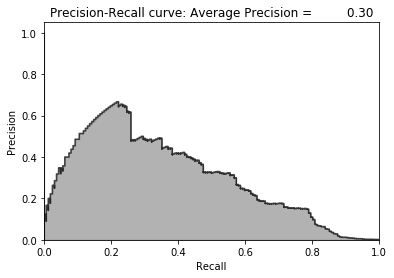

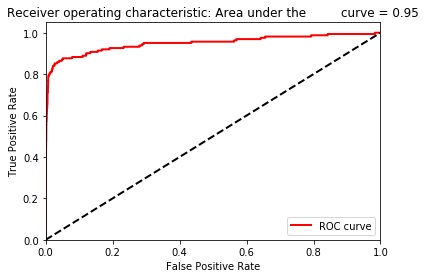

Train on 190820 samples, validate on 190820 samples
Epoch 1/10
190820/190820 [==============================] - 12s 63us/step - loss: 0.3536 - acc: 0.5261 - val_loss: 0.2794 - val_acc: 0.5588
Epoch 2/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2828 - acc: 0.5694 - val_loss: 0.2774 - val_acc: 0.5688
Epoch 3/10
190820/190820 [==============================] - 11s 59us/step - loss: 0.2799 - acc: 0.5758 - val_loss: 0.2758 - val_acc: 0.5783
Epoch 4/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2776 - acc: 0.5804 - val_loss: 0.2790 - val_acc: 0.5761
Epoch 5/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2785 - acc: 0.5812 - val_loss: 0.2759 - val_acc: 0.5843
Epoch 6/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2779 - acc: 0.5835 - val_loss: 0.2747 - val_acc: 0.5754
Epoch 7/10
190820/190820 [==============================] - 11s 58us/step - loss: 0.2776 - acc: 0.5814 - val

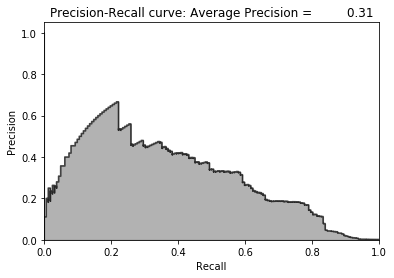

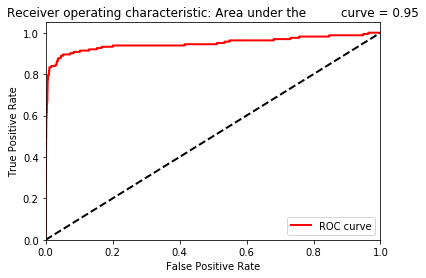

Mean average precision over 10 runs:  0.3082224128024728


[0.3128533117681673,
 0.306225411215005,
 0.3054432902975236,
 0.2975591444197734,
 0.3162783938003022,
 0.31579284977471384,
 0.30475763523130645,
 0.3120391331967438,
 0.3037209300617197,
 0.3075540282594726]

In [28]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 20 nodes
    model.add(Dense(units=20, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

The results of  this autoencoder are notedly much better: 0.31 accuracy. But the dispersion is now much tighter: 0.03.



## Two-Layer Undercomplete Autoencoder with a Linear activation function with 27 Nodes

There are several ways to modify the autoencoder. For example, we can add a bit more nodes, 27 instead of 20 in the hidden layer.


In [0]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 27 nodes
    model.add(Dense(units=27, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores


```
Mean average precision over 10 runs:  0.5273341559141779
Coefficient of variation over 10 runs:  0.5006880691999009

[0.689799495450694,
 0.7092146840717755,
 0.7336692377321005,
 0.6154173765950426,
 0.7068800243349335,
 0.35250757724667586,
 0.6904117414832501,
 0.02335388808244066,
 0.690798140588336,
 0.061289393556529626]
 ```
 
 The results have markedly improved: in some runs, the accuracy reaches .73, which is better than with the unsupervised learning solution from the earlier chapter. The dispersion is reasonably good: 0.5.
 
 
 ### Adding More Hidden Layers
 
 Now, let's add an extra hidden layer. The activation function will remain linear. We will use one hidden layer with 28 nodes and another with 27. This is now a three-layer network.
 

In [0]:
# Model three
# Three layer undercomplete autoencoder with linear activation
# With 28 and 27 nodes in the two hidden layers, respectively

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function to input layer
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 28 nodes
    model.add(Dense(units=28, activation='linear',input_dim=29))
    model.add(Dense(units=27, activation='linear'))

    # Apply linear activation function to second hidden layer
    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

```
Mean average precision over 10 runs:  0.36075271075596366
Coefficient of variation over 10 runs:  0.9361649046827353

[0.02259626054852924,
 0.6984699403560997,
 0.011035001202665167,
 0.06621450000830197,
 0.008916986608776182,
 0.705399684020873,
 0.6995233144849828,
 0.008263068338243631,
 0.6904537524978872,
 0.6966545994932775]
 ```
 
 The results are now much worse. Not only the average accuracy worsened to 0.36 compared to the previous accuracy of 0.53 but also the dispersion is now much higher: 0.94
 
 
 ## Nonlinear Autoencoder
 
 For the next design iteration, we will try a non-linear activation function: ReLU. We will use three hidden layers, with 27, 22, and 27 nodes respectively.


In [0]:
# Model four
# Four layer undercomplete autoencoder with ReLu activation
# 29 -> 27 -> 22 -> 27 -> 29

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply ReLu throughout
    # Generate first hidden layer with 27 nodes
    # Generate second hidden layer with 22 nodes
    model.add(Dense(units=27, activation='relu',input_dim=29))
    model.add(Dense(units=22, activation='relu'))

    # Apply ReLu throughout
    # Generate third hidden layer with 27 nodes
    # Generate output layer with 29 nodes
    model.add(Dense(units=27, activation='relu'))
    model.add(Dense(units=29, activation='relu'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

```
Mean average precision over 10 runs:  0.23145337591038948
Coefficient of variation over 10 runs:  0.05189289018090329

[0.22844607905495204,
 0.22790014970073896,
 0.2082714667223804,
 0.22814962996729932,
 0.24775474069244272,
 0.2279213084163665,
 0.21782962431197758,
 0.2465497864166432,
 0.2422849929178301,
 0.23942598090326406]
 ```
 
 The results are considerably worse. The mean average precision is now at 0.23, however, the dispersion is very tight at 0.05.
 
 It may be so that for this dataset a linear undercomplete autoencoder is the best solution. Other datasets may behave differently.
 
 We have been changing the number of nodes, the number of layers, the type of the activation function. This has been *hyperparameter optimization*.
 
 
 ## Overcomplete Autoencoder with Linear Activation
 
 We would like to highlight the problem with the overcomplete autoencoders. They have more nodes than the input dimensions. This *high capacity* allows them to memorize the identity function (i.e. the input) which leads to overfitting and bad generalization and bad performance on previously unseen data.
 
 In our case, we need some loss in the reconstruction. The loss is caused by not perfect learning of the inputs. The information lost comes from anomalies (i.e. fraudulent transactions). This allows us di distinguish genuine transactions (best restored) from fraudulent (worst restored).
 
 But now, we try an overcomplete  autoencoder:
 

In [0]:
# Model five
# Two layer overcomplete autoencoder with linear activation
# 29 -> 40 -> 29

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Apply linear activation function throughout
    # Generate first hidden layer with 40 nodes
    model.add(Dense(units=40, activation='linear',input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

```
Mean average precision over 10 runs:  0.3061984081568074
Coefficient of variation over 10 runs:  0.8896926168864564

[0.03394897465567298,
 0.14322827274920255,
 0.03610123178524601,
 0.019735235731640446,
 0.012571999125881042,
 0.6788921569665146,
 0.5411349583727725,
 0.388474572258503,
 0.7089617645810736,
 0.4989349153415674]
 ```
 
The training has been performed with minimal loss, as expected. But the anomaly detection accuracy is very low and varies much: 0.31 and .89 respectively.
 
 We can improve an overcomplete autoencoder by using regularization to reduce overfitting. One such technique is known as *dropout*. With it, we force the autoencoder to drop some defined percentage of units from the layers in the neural network.
 
 This will prevent the autoencoder from memorizing the inputs and make it generalize a bit more.
 
 Out dropout is set to 10%, that is, 10% of the neuron in the network are dropped. The higher the dropout, the stronger is the regularization.

In [0]:
# Model six
# Two layer overcomplete autoencoder with linear activation and dropout
# 29 -> 40 -> 29
# Dropout percentage: 10%

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',input_dim=29))
    model.add(Dropout(0.10))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

```
Mean average precision over 10 runs:  0.21150451381770646
Coefficient of variation over 10 runs:  0.40295807771579256

[0.22549974304927337,
 0.22451178120391296,
 0.17243952488912334,
 0.2533716906936315,
 0.13251890273915556,
 0.1775116247503748,
 0.4343283958332979,
 0.10469065867732033,
 0.19480068075466764,
 0.19537213558630712]
 ```
 
 Despite some regularization, the accuracy remains very low.
 
 
 ## Sparse Overcomplete Autoencoder with Linear Activation
 
Another regularization technique is enforcing of sparsity on the autoencoder. This means that a certain percentage of neurons in the network will remain inactive during the training. This makes it harder for the autoencoder to memorize inputs.
 
We will use a single hidden overcomplete autoencoder with 40 nodes but without dropout.

In [0]:
# Model seven
# Two layer sparse overcomplete autoencoder with linear activation
# 29 -> 40 -> 29

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

```
Mean average precision over 10 runs:  0.21373659011504448
Coefficient of variation over 10 runs:  0.9913040763536749

[0.1370972172100049,
 0.28328895710699215,
 0.6362677613798704,
 0.3467265637372019,
 0.5197889253491589,
 0.01871495737323161,
 0.0812609121251577,
 0.034749761900336684,
 0.04846036143317335,
 0.031010483535317393]
 ```
 
 The results have worsened, the average precision of 0.21 is still too far low from the autoencoder's best 0.53. The variation is also extremely large: 0.99.
 
 ## Sparse Overcomplete Autoencoder with Linear Activation and Dropout
 
 The next step in the experiment is to try sparsity and dropout together. We set up an autoencoder with a single 40-node layer and a dropout of 5%:

In [0]:
# Model eight
# Two layer sparse overcomplete autoencoder with linear activation and dropout
# 29 -> 40 -> 29
# Dropout percentage: 5%

# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

```
Mean average precision over 10 runs:  0.2426994231628755
Coefficient of variation over 10 runs:  0.6153219870606188

[0.6078198313533932,
 0.20862366991302814,
 0.25854513247057875,
 0.08496595007072019,
 0.26313491674585093,
 0.17001322998258625,
 0.15338215561753896,
 0.1439107390306835,
 0.4073422280287587,
 0.1292563784156162]
 ```
 
 Still, the results are not satisfactory.
 
 ## Working with Noisy Datasets
 
 A common real-world problem is noisy data. The noise can appear because of the problems in the data collection, data migration or transformation. We need autoencoders to be robust to deal with data noise.
 
 To simulate noise, let's add Gaussian random noise to the training and test datasets.
 

In [0]:
noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    

# Denoising Autoencoder

The penalty for overfitting the training data is much higher when the data is noisy. The ability to generalize decreases it the autoencoder cannot distinguish the noise and includes it into the reconstruction. 

We want an autoencoder that can learn the underlying structure of the data and discard noise.

We will try several variations: a single hidden layer, 27-node undercomplete  autoencoder with linear activation. Next, we will try a single hidden layer, 40-node sparse overcomplete autoencoder with dropout. Finally, we will use an autoencoder with a nonlinear activation.


## Two-Layer Denoising Undercomplete Autoencoder with Linear Activation

A similar autoencoder achieved0.69 average precision on the dataset without noise. Now, let's try it on the noisy data. Because this autoencoder is working on a noisy dataset and is trying to denoise  it is known as __denoising autoencoder__.

So, 1 hidden layer, 27 nodes, linear activation:


In [0]:
# Model nine
# Two layer denoising undercomplete autoencoder with linear activation
# 29 -> 27 -> 29

# 10 runs - We will capture mean of average precision
test_scores = []

    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 27 nodes using linear activation
    model.add(Dense(units=27, activation='linear', input_dim=29))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

```
Mean average precision over 10 runs:  0.2825997155005206
Coefficient of variation over 10 runs:  1.1765416185187383

[0.6929639885685303,
 0.008450118408150287,
 0.6970753417267612,
 0.011820311633718597,
 0.008924124892696377,
 0.010639537507746342,
 0.6884911855668772,
 0.006549332886020607,
 0.6805304226634528,
 0.02055279115125298]
 ```
 
 The average precision has dropped to 0.28. This is now difficult it has become for the autoencoder to work with noisy data.
 
 ## Two-Layer Denoising Overcomplete Autoencoder with Linear Activation
 
 Now, we try an overcomplete  autoencoder with a sparsity regularizer and dropout of 0.05:
 
 

In [0]:
# Model ten
# Two layer denoising overcomplete autoencoder with linear activation
# And sparsity regularizer and dropout
# 29 -> 40 -> 29
# Dropout percentage: 5%

# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='linear',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

```
Mean average precision over 10 runs:  0.10112931070692295
Coefficient of variation over 10 runs:  0.8343774832756188

[0.08283546387140524,
 0.043070120657586454,
 0.018901753737287603,
 0.02381040174486509,
 0.16038446580196433,
 0.03461061251209459,
 0.17847771715513427,
 0.2483282420447288,
 0.012981344347664117,
 0.20789298519649893]
```


 
 The noisy data also had a negative effect on the performance of the sparse overcomplete autoencoder.
 
 ## Two-Layer Overcomplete Autoencoder with ReLU Activation
 
 Finally, we swap the linear activation function in the previous version of the autoencoder with a nonlinear ReLU function.

In [0]:
# Model eleven
# Two layer denoising overcomplete autoencoder with ReLU activation
# And sparsity regularizer and dropout
# 29 -> 40 -> 29
# Dropout percentage: 5%

# 10 runs - We will capture mean of average precision
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape) 
    
for i in range(0,10):
    # Call neural network API
    model = Sequential()

    # Generate hidden layer with 40 nodes using linear activation
    model.add(Dense(units=40, activation='relu',  \
        activity_regularizer=regularizers.l1(10e-5), input_dim=29))
    model.add(Dropout(0.05))

    # Generate output layer with 29 nodes
    model.add(Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores


```
Mean average precision over 10 runs:  0.1969608394689088
Coefficient of variation over 10 runs:  0.5566706365802669

[0.22960316854089222,
 0.37609633487223315,
 0.11429775486529765,
 0.10208135698072755,
 0.4002384343852861,
 0.13317480663248088,
 0.15764518571284625,
 0.2406315655171392,
 0.05080529996343734,
 0.1650344872187474]

```


 Here, we show some improvement when using a nonlinear activation. Still, the dense undercomplete linear activation autoencoder worked better even on the noisy data.